## Network model class 

Can be adjusted for future use.
Author @ysbecca

In [1]:
import tensorflow as tf
import scripts.cnn_helper as cn
import scripts.dataset as ds
from tensorflow.python.client import device_lib
import math
from importlib import reload
import matplotlib.pyplot as plt

import numpy as np

Case start, end:  0 50


In [2]:
reload(cn)
reload(ds)

<module 'scripts.dataset' from '/Users/ysbecca/ysbecca-projects/bcsp-expert/scripts/dataset.py'>

Have the model architecture parameters defined in a config file called `model_config.py`. For this notebook, the contents of `model_config` will be as defined below.

In [3]:
# Input parameters
img_size = 256
num_channels = 9

img_size_flat = img_size * img_size * num_channels
img_shape = (img_size, img_size)

# Convolutional layer parameters
filter_sizes = [7, 5, 3, 1]
num_filters = [16, 16, 16, 32]
num_layers = len(filter_sizes)
max_pools = [2, 2, 2, 2]
relu = [1, 1, 1, 1]

fc_sizes = [256, 128]
num_classes = 2

# Training params
train_batch_size = 4
test_batch_size = 4


# Directories
model_dir = ""
checkpoints_dir = ""


# To read the case numbers selected
csv_name = "/Users/ysbecca/ysbecca-projects/bcsp-expert/data/temp_cases.csv"

# General high directory containing all the cases
img_dir = "/Users/ysbecca/ysbecca-projects/bcsp-expert/data/wsi_samples/"

# Where to save the created h5 and csv files
test_db_dir = "/Users/ysbecca/ysbecca-projects/bcsp-expert/data/temp_db/"

# Where to find the JSON or XML annotation files
xml_dir = "/Users/ysbecca/ysbecca-projects/bcsp-expert/annotations/test_set/"


# For patch sampling =========================================================
case_start = 0
case_end = 2

print("Case start, end: ", case_start, case_end)

folder_prefix = "Case_"
base_patch_size = 256
patch_sizes = [512, 1024, 2048]
level = 0
pixel_overlap = 0
samples_per_patch = len(patch_sizes)


chunk_size = 2000

# For image quality downsampling.
downsamples = [2, 4, 8]

# Downsampling annotated regions for quickly labeling patches
annotation_downsample = 10

label_map = {"EP": 0,
             "SM": 1,
             "U": -1} # Unknown

Case start, end:  0 2


Now define the network model.

In [17]:
class CNN_Model():
    
    def __init__(self, 
                 total_k,
                 name="CNN Model",
                 learning_rate=1e-4,
                 pretrained_epochs=0,
                 pretrained_model=False,
                 weights_array=[],
                ):
        ''' Initalises all the network parameters and starts a TF session. '''
        
        self.total_k = total_k
        self.weights_array = weights_array
        self.epochs = pretrained_epochs
        
        # Load pre-trained model, if provided.
        self.pretrained_model = pretrained_model
    
        self.name = name
    
        self.valid = None
        self.train = None
        
        # Initialises the TF session and loads pretrained model if it exists.
        
        # Build tensors.
        self.x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name="x")
        self.x_image = tf.reshape(self.x, [-1, img_size, img_size, num_channels], name="x_image")
        
        #self.weights = tf.placeholder(tf.float32, shape=[None], name='weights')
        
        self.y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name="y_true")
        self.y_true_cls = tf.argmax(self.y_true, dimension=1, name="y_true_cls")

        self.keep_prob = tf.placeholder(tf.float32, name="keep_prob") # Dropout control.
        self.gpus = self.__get_gpus()
        
        
        if len(self.gpus) > 0:
            # Remember that this adds significant latency for CPU<->GPU copying of shared variables.
            # 2 GPU's is enough to get a good balance between speedup and minimal latency (12 GB on k80 nodes)
            self.y_pred, self.y_pred_cls, self.cost = self.make_parallel(self.model, 
                                                     x_image_=self.x_image, 
                                                     y_true_=self.y_true)
                                                     #weights_=self.weights)
            total_batches = len(self.gpus)
        else:
            # CPU-only version
            self.y_pred, self.y_pred_cls, self.cost = self.model(x_image_=self.x_image, 
                                                       y_true_=self.y_true)
                                                       #weights_=self.weights)
            total_batches = 1

            
        self.train_batch_size = train_batch_size * total_batches
        self.test_batch_size = test_batch_size * total_batches
    
        self.optimizer = tf.train.AdagradOptimizer(learning_rate=
                                              learning_rate).minimize(self.cost, 
                                                                      colocate_gradients_with_ops=True)
        correct_prediction = tf.equal(self.y_pred_cls, self.y_true_cls)
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
        if len(self.gpus) > 0: # Log GPU/CPU placement to the terminal if using GPU's.
            self.session = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
        else:
            self.session = tf.Session()

        self.session.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()
        
        # Load pretrained model
        if self.pretrained_model:
            self.restore_model(self.pretrained_model)
    
    
    def model(self, x_image_, y_true_):
        ''' Defines the model which can be copied to each GPU device being used. '''

        model = x_image_
        num_filters_ = [num_channels] + num_filters
        print("Num Filters:", num_filters_)
        print("Filter sizes:", filter_sizes)

        for i in range(num_layers):
            print("i:", i)
            print("Input channels:", num_filters_[i])
            print("Filter sizes:", filter_sizes[i])
            
            model = cn.new_conv_layer(input=model,
                                          num_input_channels=num_filters_[i],
                                          filter_size=filter_sizes[i],
                                          num_filters=num_filters_[i+1],
                                          use_pooling=True,
                                          max_pool_size=max_pools[i],
                                          use_relu=relu[i])
            model = tf.nn.dropout(model, self.keep_prob)
            print(model)


        model, num_fc_features = cn.flatten_layer(model)
        print(num_fc_features)

        if len(fc_sizes) > 0:
            fc_sizes_ = [num_fc_features] + fc_sizes

            # The flattened features will then be fed into the fully-connected layers.
            for i in range(len(fc_sizes)):
                model = cn.new_fc_layer(input=model,          
                                     num_inputs=fc_sizes_[i],
                                     num_outputs=fc_sizes_[i+1],
                                     use_relu=True)
                model = tf.nn.dropout(model, self.keep_prob)

            num_fc_features = fc_sizes_[-1]

        model = cn.new_fc_layer(input=model,          
                                 num_inputs=num_fc_features,
                                 num_outputs=num_classes,
                                 use_relu=True)

        y_pred = tf.nn.softmax(model)
        y_pred_cls = tf.argmax(model, dimension=1)
        cost = tf.reduce_mean(tf.losses.softmax_cross_entropy(logits=model, onehot_labels=y_true_))
                                                              #, weights=weights_))
        return y_pred, y_pred_cls, cost
        
    
    def train(self, k, valid_k, epochs, verbose=True, dropout_keep_prob=0.9, show_valid_acc=True):
        ''' Train the network for the given number of epochs. '''
        print("in")
        start_time = time.time()
        
        # Load k training set and valid_k set.
        if not self.train:
            self.load_train_dataset(k)
        
        if show_valid_acc and not self.valid:
            self.load_valid_dataset(valid_k)
        
        # Calculate the number of iterations required for one epoch.
        iterations_per_epoch = int(math.ceil(self.train.num_images / self.train_batch_size))
        iterations = iterations_per_epoch * epochs
        
        # Optimise.
        acc = self.optimize(self.train, iterations, dropout_keep_prob, verbose, show_valid_acc)
        print("Epoch", epochs, "..................... Train accuracy:", acc)
        
        end_time = time.time()
        time_dif = end_time - start_time
        if verbose:
            print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

    
    def load_valid_dataset(self, valid_k):
        self.valid = ds.read_k_dataset(valid_k, self.total_k, shuffle_all=True, do_augments=False)
        
    def load_train_dataset(self, train_k):
        self.train = ds.read_k_dataset(train_k, self.total_k, shuffle_all=True, do_augments=True)
    
    def get_accuracy(self, dataset, show_conf_matrix=True, verbose=True, get_outputs=False):
        ''' Computes validation/test accuracy; used during training and as a standalone function. Batch
            size is test_batch_size since forward pass only. '''
        
        if not dataset:
            print("OUPS! No dataset loaded.")
            return -1.0
            
        # Calculate accuracy.
        num_test = len(dataset.images)

        cls_pred = np.zeros(shape=num_test, dtype=np.int)
        i = 0

        while i < num_test:
            j = min(i + test_batch_size, num_test)
            curr_batch_size = j - i

            # Get the images and targets from the test-set between index i and j.
            images = dataset.images[i:j, :].reshape(curr_batch_size, img_size_flat)
            labels = dataset.labels[i:j, :]
            
            print(images.dtype)
            print(np.shape(images))
            print(np.shape(labels))
            
            #weights_ = np.ones((curr_batch_size))
            feed_dict = {self.x: images, self.y_true: labels, self.keep_prob: 1.0}
            
            if get_outputs: # NON thresholded outputs
                cls_pred[i:j] = self.session.run(self.y_true, feed_dict=feed_dict)
            else:
                cls_pred[i:j] = self.session.run(self.y_pred_cls, feed_dict=feed_dict)
            i = j

        # TODO Define differently depending on valid / test and problem...
        cls_true = [np.argmax(label) for label in dataset.labels]

        # Create a boolean array whether each image is correctly classified.
        correct = (cls_true == cls_pred)

        correct_sum = correct.sum() # sum(1 for a, b in zip(cls_true, cls_pred) if a and b)
        acc = float(correct_sum) / num_test

        if verbose:
            msg = "ACCURACY: {0:.1%} ({1} / {2})"
            print(msg.format(acc, correct_sum, num_test))
        
        if show_conf_matrix:
            cm = cn.plot_confusion_matrix(cls_true, cls_pred=cls_pred, show_plt=True)
            
        return acc, cm, cls_pred
        
    
    def get_outputs(self, k, shuffle=False, augment=False, thresholded=True):
        ''' Retrieves the softmax outputs for a random k set and returns. '''
        dataset = self.load_k_set(k, shuffle=shuffle, augment=augment)
        
        acc, cm, cls_pred = self.get_accuracy(dataset, show_conf_matrix=False, verbose=False, get_outputs=thresholded)
        
        return cls_pred
    
    def save_outputs(self, k, outputs):
        ''' Saves softmax outputs to a file. '''
        
        #TOOD save outputs into specified directory in a good format.
        print("Oups! Not implemented yet.")
        return -1
    
    def load_k_set(self, k, shuffle, augment):
        ''' Loads the kth set without setting the self.train or self.valid variables. '''
        return ds.read_k_dataset(k, self.total_k, shuffle_all=shuffle, do_augments=augment)
    
    def __get_gpus(self):
        return [x.name for x in device_lib.list_local_devices() if x.device_type == 'GPU']
    
    def make_parallel(self, fn, **kwargs):
        ''' Splits the model across available GPUs. '''
        in_splits = {}
        for k, v in kwargs.items():
            in_splits[k] = tf.split(v, num_gpus)

        y_pred_split, y_pred_cls_split, cost_split = [], [], []
        for i in range(num_gpus):
            with tf.device(tf.DeviceSpec(device_type="GPU", device_index=i)):
                with tf.variable_scope(tf.get_variable_scope(), reuse=i > 0):
                    y_pred_, y_pred_cls_, cost_ = fn(**{k : v[i] for k, v in in_splits.items()})
                    y_pred_split.append(y_pred_)
                    y_pred_cls_split.append(y_pred_cls_)
                    cost_split.append(cost_)

        return tf.concat(y_pred_split, axis=0), tf.concat(y_pred_cls_split, axis=0), \
                tf.stack(cost_split, axis=0)
    
    # Saving and restoring models.
    def save_model(self, k, epochs=0):
        model_name = 'm-' + datetime.datetime.now().strftime("%Y-%m-%d-%H-%M") + "-" + str(k) + "-" + str(epochs)
        self.saver.save(self.session, checkpoints_dir + model_name)
        print("CNN Model saved for k=", k, ":", model_name)
        
        return model_name

    def restore_model(self, model_name):
        output = self.saver.restore(sess=self.session, save_path=checkpoints_dir + model_name)
        print(output)

    def optimize(self, dataset, num_iterations, dropout_keep_prob, verbose, show_valid_acc, valid_interval=100):
        ''' Optimises for the given number of iterations by batches. '''
        total_iterations = 0
        
        for i in range(total_iterations,
                       total_iterations + num_iterations):
            x_batch, y_true_batch = dataset.next_batch(train_batch_size)
            x_batch = x_batch.reshape(len(x_batch), img_size_flat)

            #weights_ = generate_batch_weights(y_true_pseudo)
            feed_dict_train = {self.x: x_batch, self.y_true: y_true_batch, self.keep_prob: dropout_keep_prob}
            
            if i % valid_interval and show_valid_acc:
                acc, _, _ = self.get_accuracy(self.valid, show_conf_matrix=False)
                msg = "Validation Accuracy:    {1:>6.1%}"
                print(msg.format(acc), " Iterations: ", total_iterations)

            self.session.run(self.optimizer, feed_dict=feed_dict_train)

        acc = self.session.run(self.accuracy, feed_dict=feed_dict_train)
        total_iterations += num_iterations
        
        if verbose:
            msg = "Training Accuracy:      {1:>6.1%}"
            print(msg.format(acc), " Iterations: ", total_iterations)
        
        return acc


Now let's try the class.

In [18]:
cnn_model = CNN_Model(total_k=10, name="Test-CNN-Model", pretrained_epochs=0, pretrained_model=False)

Num Filters: [9, 16, 16, 16, 32]
Filter sizes: [7, 5, 3, 1]
i: 0
Input channels: 9
Filter sizes: 7
Tensor("Conv2D_8:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("Relu_14:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("MaxPool_8:0", shape=(?, 128, 128, 16), dtype=float32)
Tensor("dropout_12/mul:0", shape=(?, 128, 128, 16), dtype=float32)
i: 1
Input channels: 16
Filter sizes: 5
Tensor("Conv2D_9:0", shape=(?, 128, 128, 16), dtype=float32)
Tensor("Relu_15:0", shape=(?, 128, 128, 16), dtype=float32)
Tensor("MaxPool_9:0", shape=(?, 64, 64, 16), dtype=float32)
Tensor("dropout_13/mul:0", shape=(?, 64, 64, 16), dtype=float32)
i: 2
Input channels: 16
Filter sizes: 3
Tensor("Conv2D_10:0", shape=(?, 64, 64, 16), dtype=float32)
Tensor("Relu_16:0", shape=(?, 64, 64, 16), dtype=float32)
Tensor("MaxPool_10:0", shape=(?, 32, 32, 16), dtype=float32)
Tensor("dropout_14/mul:0", shape=(?, 32, 32, 16), dtype=float32)
i: 3
Input channels: 16
Filter sizes: 1
Tensor("Conv2D_11:0", shape=(?, 32, 32, 3

In [19]:
print(cnn_model)
print(cnn_model.name)
print(cnn_model.total_k)

Test-CNN-Model
10


In [20]:
dataset = cnn_model.load_k_set(0, shuffle=False, augment=False)

Cases:            ['0025', '0037']
Ground truth:     []
Selected:         [ 1.  0.]
Before stacking:  (3, 12, 256, 256, 3)
After stacking:   (12, 256, 256, 9)
LOADED k-set:     0
(12, 256, 256, 9)
(12, 2)
(12, 2)
(12,)


float32
(4, 589824)
(4, 2)
float32
(4, 589824)
(4, 2)
float32
(4, 589824)
(4, 2)
ACCURACY: 100.0% (12 / 12)
[[12]]


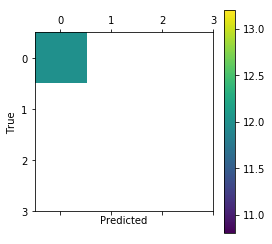

(1.0, None, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [21]:
cnn_model.get_accuracy(dataset, show_conf_matrix=True, verbose=True, get_outputs=False)

In [ ]:
x = 1.0